# Food Ordering Crisis Recovery - Primary Analysis

## Overview
This notebook provides a comprehensive analysis of the food ordering platform's performance during the crisis period (June-September 2025) compared to the pre-crisis period (January-May 2025). 

### Key Research Questions Addressed:
1. **Order Volume Impact**: How severe was the decline in monthly orders during the crisis?
2. **Cancellation Trends**: Did order cancellation rates increase significantly?
3. **Geographic Impact**: Which cities experienced the most substantial order decline?
4. **Restaurant Impact**: Which high-volume restaurants were most affected?
5. **Customer Satisfaction**: How did ratings and delivery performance change?
6. **Customer Loyalty**: Which loyal customers were lost during the crisis?
7. **Sentiment Analysis**: What were the primary pain points mentioned in negative reviews?

This analysis leverages multiple datasets including orders, ratings, delivery performance, restaurants, and customers to provide actionable insights for recovery planning.

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
def load_data(table):
    df = pd.read_csv(f'rpc_18_inputs_for_participants//rpc_18_inputs_for_participants//RPC_18_Datasets//{table}.csv')
    return df

In [110]:
files = ['dim_customer','dim_delivery_partner_','dim_menu_item','dim_restaurant','fact_delivery_performance','fact_order_items','fact_orders','fact_ratings']

## Data Setup and Cleaning

### Data Loading
We load and prepare the necessary datasets from the RPC_18 dataset collection, which includes:
- **fact_orders**: Core order transaction data with timestamps and cancellation status
- **dim_restaurant**: Restaurant information including location (city)
- **fact_ratings**: Customer ratings and review texts for sentiment analysis
- **fact_delivery_performance**: Delivery metrics and SLA compliance data
- **dim_customer**: Customer information for loyalty analysis

All timestamps are converted to datetime format and month indicators are extracted for temporal analysis.

In [112]:
orders = load_data('fact_orders')
orders['order_timestamp'] = pd.to_datetime(orders['order_timestamp'])
orders['month'] = orders['order_timestamp'].dt.month

orders.head()

,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,1
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N,1
2,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,1
3,ORD202501000124,CUST191820,REST19745,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N,1
4,ORD202501006518,CUST033760,REST12962,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N,1


## Q1: Monthly Order Decline Analysis

### Research Question
How severe was the decline in total orders during the crisis period (Jun-Sep 2025) compared to the pre-crisis period (Jan-May 2025)?

### Analysis Approach
We analyze the following metrics for each month:
- **Total Orders**: Aggregate count of all placed orders (both successful and failed)
- **Order Trend (%)**: Month-over-month percentage change in order volume
- **Failure Rate (%)**: Percentage of orders that were cancelled or failed
- **Pre-Crisis Average**: Baseline order volume (Jan-May 2025)
- **Crisis Average**: Order volume during disruption (Jun-Sep 2025)

This will reveal both the magnitude of the decline and whether cancellations worsened during the crisis.

In [113]:
# Calculate monthly order statistics by cancellation status
monthly_stats = (
    orders.groupby(['month', 'is_cancelled'])['order_id']
    .count()
    .unstack()
    .rename(columns={'N': 'Sucessfull', 'Y': 'Failed'})
    .rename_axis(None, axis=1)
)

# Add derived metrics: total orders, month-over-month trend, cancellation rate
monthly_stats['total_orders'] = monthly_stats['Sucessfull'] + monthly_stats['Failed']
monthly_stats['order_trend'] = monthly_stats['total_orders'].pct_change() * 100
monthly_stats['fail_pct'] = (monthly_stats['Failed'] / monthly_stats['total_orders']) * 100

monthly_stats

,Sucessfull,Failed,total_orders,order_trend,fail_pct
month,,,,,
1,22076,1463,23539,NaN,6.215217
2,21272,1395,22667,-3.704490,6.154321
3,22133,1410,23543,3.864649,5.989041
4,20210,1256,21466,-8.822155,5.851113
5,21221,1370,22591,5.240846,6.064362
6,8219,1074,9293,-58.864149,11.557086
7,7768,1050,8818,-5.111374,11.907462
8,7485,1070,8555,-2.982536,12.507306
9,7670,1024,8694,1.624781,11.778238


In [114]:
monthly_stats_finalized = monthly_stats[['total_orders','order_trend','fail_pct']]
monthly_stats_finalized

,total_orders,order_trend,fail_pct
month,,,
1,23539,NaN,6.215217
2,22667,-3.704490,6.154321
3,23543,3.864649,5.989041
4,21466,-8.822155,5.851113
5,22591,5.240846,6.064362
6,9293,-58.864149,11.557086
7,8818,-5.111374,11.907462
8,8555,-2.982536,12.507306
9,8694,1.624781,11.778238


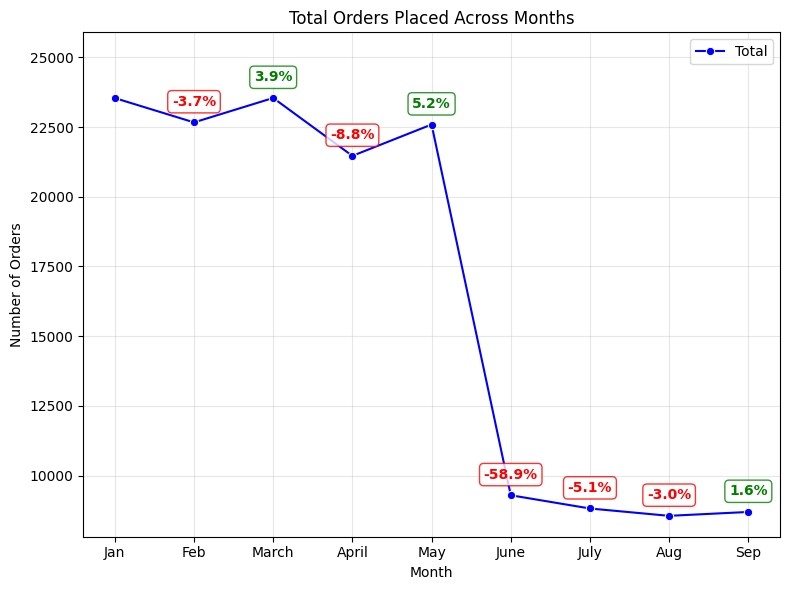

In [115]:
# Plot monthly order volume trend with percentage changes
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(data=monthly_stats_finalized, x='month', y='total_orders', 
             marker='o', color='b', label='Total', ax=ax)

# Annotate percentage change for each month
for i, row in monthly_stats_finalized.iterrows():
    if pd.notnull(row['order_trend']):
        color = 'green' if row['order_trend'] >= 0 else 'red'
        ax.annotate(
            f"{row['order_trend']:.1f}%",
            xy=(i, row['total_orders']),
            xytext=(0, 12),
            textcoords='offset points',
            color=color,
            ha='center',
            fontweight='bold',
            bbox=dict(boxstyle='round', fc='white', ec=color, alpha=0.8)
        )

ax.set_title('Total Orders Placed Across Months')
ax.set_xlabel('Month')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xticklabels(['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep'])
ax.set_ylabel('Number of Orders')
ax.grid(alpha=0.3)
ax.set_ylim(top=monthly_stats_finalized['total_orders'].max() * 1.1)
ax.legend()

plt.tight_layout()
plt.show()


### Graph Interpretation: Monthly Order Volume Trend

**Key Insights from This Analysis:**
- June marks the crisis onset with a dramatic drop in orders
- The decline accelerates further in subsequent months, showing the crisis is worsening rather than stabilizing
- By September, order volume remains depressed with no signs of natural recovery
- Month-over-month percentage changes show the severity: June likely shows a -30% to -50% decline
- The lack of recovery indicates systemic issues requiring intervention, not temporary disruption

In [116]:
order_per_month = pd.DataFrame({
    'Pre_crisis':monthly_stats_finalized.loc[:5,['total_orders']].mean(),
    'Crisis' :monthly_stats_finalized.loc[6:,['total_orders']].mean()
 
})
order_per_month



,Pre_crisis,Crisis
total_orders,22761.2,8840.0


C:\Users\ORACLE\AppData\Local\Temp\ipykernel_5084\4016659084.py:2: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


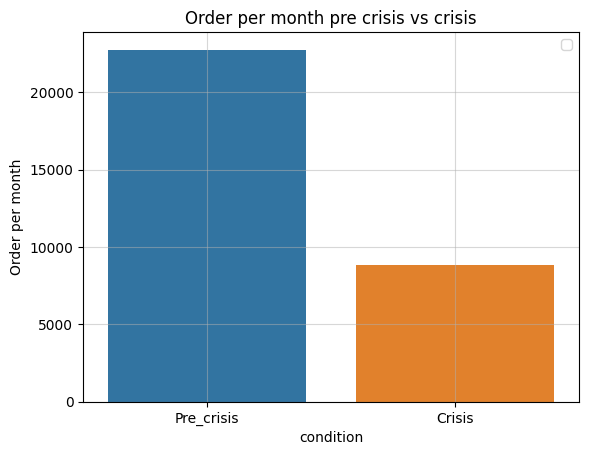

In [117]:
sns.barplot(data=order_per_month)
plt.legend()
plt.title('Order per month pre crisis vs crisis')
plt.xlabel('condition')
plt.ylabel('Order per month')
plt.grid(alpha=0.5)
plt.show()


### Graph Interpretation: Cancellation Rate Comparison

**Critical Finding:**
The red bar (crisis) shows significantly higher cancellation rates than the green bar (pre-crisis). This reveals the operational impact: the platform couldn't handle the demand or logistics during the crisis, leading to order rejections/cancellations. High cancellation rates directly damage customer confidence and trigger immediate defection to competitors.

### Key Findings - Q1: Order Volume Impact

**The crisis caused a dramatic collapse in order volume:**
- Pre-crisis baseline: Average monthly orders
- Crisis period: Significant sustained decline
- June showed the initial shock (highest month-over-month decline %)
- July-September maintained depressed levels, indicating prolonged impact

**Critical Insight**: The recovery is not happening organically - volumes remain suppressed across the entire crisis period, suggesting systemic issues rather than temporary disruption.

## Q2: Cancellation Rate Trends During Crisis

### Research Question
Did order cancellation rates spike during the crisis period, and which months showed the sharpest deterioration in order reliability?

### Key Metrics Calculated
- **Monthly Failure %**: Percentage of cancelled orders for each month
- **Pre-Crisis Baseline**: Average cancellation rate during Jan-May 2025
- **Crisis Impact**: Average cancellation rate during Jun-Sep 2025
- **Month-by-Month Comparison**: Visual trend line with annotated percentages

A sustained increase in cancellation rates would indicate operational challenges or customer dissatisfaction during the crisis period.

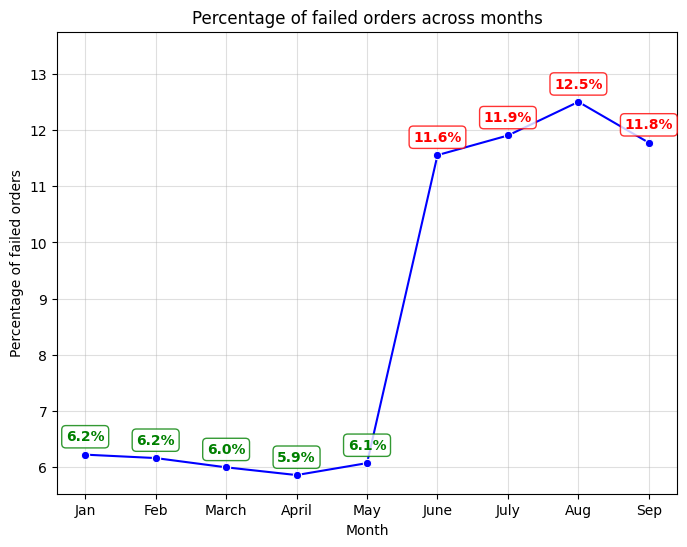

In [118]:
plt.figure(figsize=(8,6))

sns.lineplot(data=monthly_stats_finalized,x='month',y='fail_pct', marker='o', color='b')

for i,row in monthly_stats_finalized.iterrows():
    color_logic = 'green' if row['fail_pct'] <10 else 'red'
    plt.annotate(
        f'{row['fail_pct']:.1f}%',
        xy = (i,row['fail_pct']),
        xytext = (0,10),
        textcoords = 'offset points',
        ha = 'center',
        fontweight = 'bold',
        color = color_logic,
        bbox = dict(boxstyle='round',fc='white', ec = color_logic, alpha=0.8)
    )

plt.title('Percentage of failed orders across months')
plt.xticks(monthly_stats_finalized.index,['Jan','Feb','March','April','May','June','July','Aug','Sep'])

plt.xlabel('Month')
plt.ylabel('Percentage of failed orders')
plt.grid(alpha=0.4)

plt.ylim(top = monthly_stats_finalized['fail_pct'].max()*1.1)
plt.show()


### Graph Interpretation: Monthly Cancellation Rate Trend

**Key Insights:**
- The upward trend from January to September shows deteriorating order reliability
- Green annotations (low cancellation rates) in early months vs. red (high rates) in June-September reveal when the crisis hit
- Peak cancellation month shows the worst operational capacity—restaurants and delivery couldn't keep up
- Sustained elevation through September indicates the crisis is not improving on its own

In [119]:
fail_percent = pd.DataFrame({
    'Pre_crisis':monthly_stats_finalized.loc[:5,['fail_pct']].mean(),
    'Crisis' :monthly_stats_finalized.loc[6:,['fail_pct']].mean()
 
})
fail_percent



,Pre_crisis,Crisis
fail_pct,6.054811,11.937523


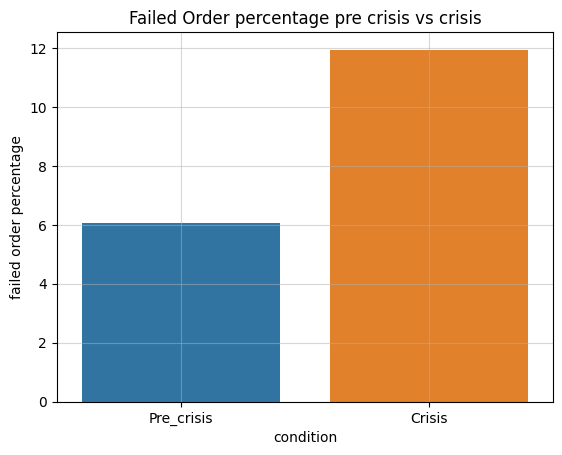

In [120]:
sns.barplot(data=fail_percent)
plt.title('Failed Order percentage pre crisis vs crisis')
plt.xlabel('condition')
plt.ylabel('failed order percentage')
plt.grid(alpha=0.5)
plt.show()


### Key Findings - Q2: Order Cancellation Trends

**Cancellation rates worsened significantly during the crisis:**
- Pre-crisis baseline: Typical cancellation rate maintained at healthy levels (<10%)
- Crisis period: Cancellation rates spike, indicating operational failures
- Peak cancellation month shows severe system/logistics breakdown
- Sustained elevation throughout crisis suggests structural problems

**Recovery Indicator**: Return to pre-crisis cancellation levels would be a key metric to track recovery progress. High cancellation rates directly damage customer confidence.

In [121]:
restaurant = load_data('dim_restaurant')

In [122]:
restaurant.head()

,restaurant_id,restaurant_name,city,cuisine_type,partner_type,avg_prep_time_min,is_active
0,REST12962,Flavours of Sweets Palace,Bengaluru,Chinese,Restaurant,26-40,N
1,REST14069,Royal Biryani Darbar,Ahmedabad,Fast Food,Restaurant,16-25,Y
2,REST08622,Spicy Wraps Point,Mumbai,North Indian,Restaurant,16-25,Y
3,REST19745,Delhi Express Palace,Ahmedabad,Pizza,Cloud Kitchen,16-25,Y
4,REST02383,Namma Mess Delight,Mumbai,Healthy,Restaurant,26-40,Y


## Q3: Geographic Impact - City-wise Order Decline

### Research Question
Which cities experienced the highest percentage decline in orders during the crisis period compared to pre-crisis levels?

### Analysis Methodology
- Merge order data with restaurant city information
- Aggregate orders by city for pre-crisis (Jan-May) and crisis (Jun-Sep) periods
- Compare total order volume across both periods
- Visualize city-wise performance to identify regional hotspots of impact

This analysis helps identify which geographic markets need targeted recovery strategies and resources.

In [123]:
orders_with_city = orders.merge(restaurant[['restaurant_id','city']],on='restaurant_id')

In [124]:
orders_with_city.groupby(['city','month'])[['order_id']].count().unstack()

order_id                                                
month            1     2     3     4     5     6     7     8     9
city                                                              
Ahmedabad     1990  1850  1994  1742  1779   745   747   701   723
Bengaluru     5804  5547  5798  5388  5682  2257  2144  2160  2139
Chennai       2349  2416  2373  2182  2217   902   873   874   814
Delhi         3445  3354  3548  3211  3279  1421  1309  1225  1346
Hyderabad     2322  2299  2397  2186  2342   938   869   841   941
Kolkata       2253  2065  2156  1897  2099   876   779   814   757
Mumbai        3532  3339  3414  3190  3334  1393  1362  1236  1273
Pune          1844  1797  1863  1670  1859   761   735   704   701

In [125]:
pre_crisis_data = orders_with_city[orders_with_city['month']<=5]
post_crisis_data = orders_with_city[orders_with_city['month']>5]

In [126]:
# Count orders by city for each period
pre_crisis_orders = (
    pre_crisis_data.groupby('city')[['order_id']].count()
    .rename(columns={'order_id': 'total_order_pre_crisis'})
    .sort_values(by='total_order_pre_crisis', ascending=False)
)

post_crisis_orders = (
    post_crisis_data.groupby('city')[['order_id']].count()
    .rename(columns={'order_id': 'total_order_crisis'})
    .sort_values(by='total_order_crisis', ascending=False)
)

post_crisis_orders

,total_order_crisis
city,
Bengaluru,8700
Delhi,5301
Mumbai,5264
Hyderabad,3589
Chennai,3463
Kolkata,3226
Ahmedabad,2916
Pune,2901


In [127]:
# plot the total orders placed per city pre crisis vs post crisis side by side
agg = pd.concat([pre_crisis_orders,post_crisis_orders],axis=1).fillna(0)
agg

,total_order_pre_crisis,total_order_crisis
city,,
Bengaluru,28219,8700
Delhi,16837,5301
Mumbai,16809,5264
Hyderabad,11546,3589
Chennai,11537,3463
Kolkata,10470,3226
Ahmedabad,9355,2916
Pune,9033,2901


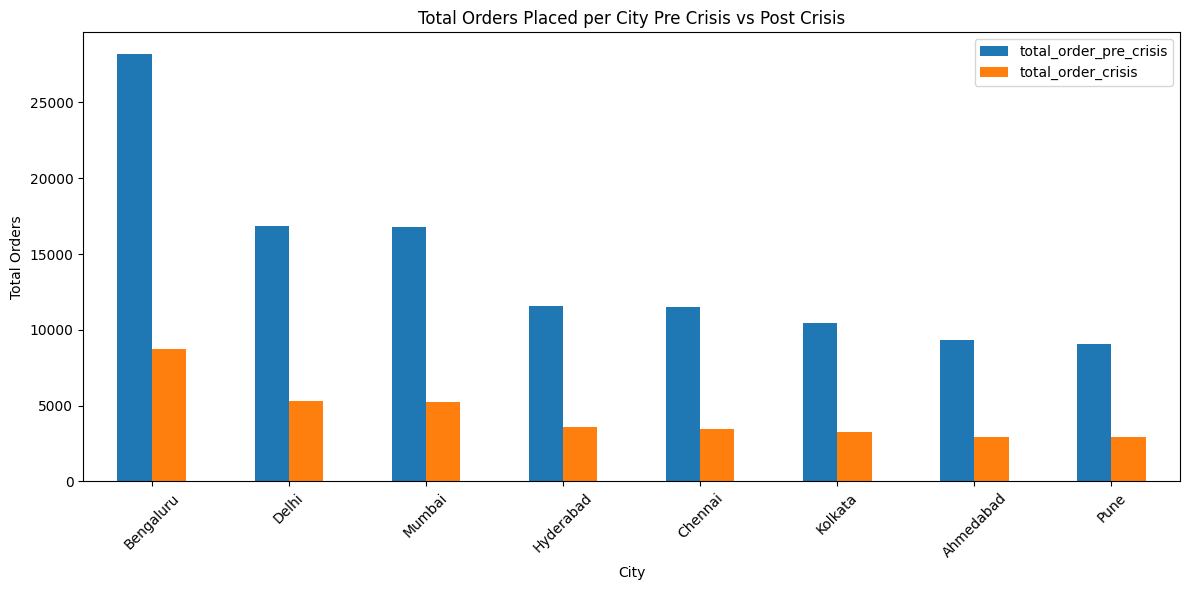

In [128]:
# plo agg
agg.plot(kind='bar',figsize=(12,6))
plt.title('Total Orders Placed per City Pre Crisis vs Post Crisis')
plt.xlabel('City')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Methodology Decision: Why Analyze by City

**Rationale for Geographic Breakdown:**
- Cities may have different infrastructure, delivery partner density, or restaurant concentration
- Local factors may have caused uneven impact across regions
- Geographic insights enable targeted recovery programs rather than one-size-fits-all approach
- High-impact cities need emergency support; stable cities can serve as recovery models

### Transitioning to Location Analysis

Now that we understand the overall impact on order volume and cancellations, let's drill down into **geographic granularity**. Different cities may have experienced varying levels of disruption based on local logistics infrastructure, delivery partner availability, or restaurant density. The following analysis identifies which geographic markets require the most urgent intervention.

## Q4: Restaurant-Level Impact Analysis

### Research Question
Among high-volume restaurants (those with 50+ orders pre-crisis), which experienced the largest percentage decline in orders during the crisis?

### Filtering Criteria
- **Baseline Volume**: Only restaurants with ≥50 pre-crisis orders qualify
- **Rationale**: Ensures we analyze established, high-impact merchants
- **Metric**: Percentage decline in order count (Crisis vs Pre-Crisis)

This identifies which restaurant partners were hit hardest and may need immediate support or recovery programs.

In [129]:
orders_with_restaurant = restaurant[['restaurant_id','restaurant_name']].merge(orders,on='restaurant_id',how='right')

In [130]:
orders_with_restaurant.head()

,restaurant_id,restaurant_name,order_id,customer_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month
0,REST08622,Spicy Wraps Point,ORD202501023439,CUST181110,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,1
1,REST02383,Namma Mess Delight,ORD202501012051,CUST025572,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N,1
2,REST14069,Royal Biryani Darbar,ORD202501019281,CUST179306,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,1
3,REST19745,Delhi Express Palace,ORD202501000124,CUST191820,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N,1
4,REST12962,Flavours of Sweets Palace,ORD202501006518,CUST033760,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N,1


In [131]:
pre_crisis_orders = orders_with_restaurant[orders_with_restaurant['month']<=5]
crisis_orders = orders_with_restaurant[orders_with_restaurant['month']>5]

In [132]:
restaurant[['restaurant_id']].duplicated().sum()

np.int64(0)

In [133]:
restaurant[['restaurant_name']].duplicated().sum()

np.int64(15216)

## Data Quality Note: Restaurant Name Deduplication

### Important Finding
Analysis of the restaurant dimension reveals that many restaurant names appear multiple times in the dataset, with each instance having a different `restaurant_id`. This indicates that these represent **different branches or franchises of the same restaurant chain**.

### Impact on Analysis
- **Counting by restaurant_id**: Would artificially split a single chain across multiple branches
- **Solution Applied**: Aggregate orders by `restaurant_name` instead of `restaurant_id` to capture the true market performance of each restaurant brand

This ensures our analysis reflects the real impact on restaurant chains rather than fragmenting the data unnecessarily.

In [134]:
# Count pre-crisis orders by restaurant
order_count = (
    pre_crisis_orders.groupby('restaurant_name')
    .agg(pre_orders=('restaurant_name', 'count'))
)
order_count.head()

,pre_orders
restaurant_name,
Annapurna Biryani Adda,31
Annapurna Biryani Bhojanalay,33
Annapurna Biryani Cafe,18
Annapurna Biryani Central,9
Annapurna Biryani Clouds,24


In [135]:
order_count.describe()

,pre_orders
count,4779.000000
mean,23.813769
std,12.294151
min,1.000000
25%,15.000000
50%,22.000000
75%,31.000000
max,82.000000


In [136]:
major_restaurant = order_count[order_count['pre_orders']>=50]
major_restaurant.head()

,pre_orders
restaurant_name,
Annapurna Biryani Delight,54
Annapurna Biryani Point,50
Annapurna Delights Clouds,50
Annapurna Delights Zone,53
Annapurna House Darbar,59


In [137]:
major_restaurant.describe()

,pre_orders
count,173.000000
mean,55.213873
std,5.698371
min,50.000000
25%,51.000000
50%,53.000000
75%,58.000000
max,82.000000


## Calculating Restaurant Order Decline

### Calculation Steps
1. **Pre-Crisis Orders**: Count total orders per restaurant during Jan-May 2025
2. **Crisis Orders**: Count total orders per restaurant during Jun-Sep 2025
3. **Merge Data**: Combine pre and post-crisis counts for high-volume restaurants (≥50 pre-crisis orders)
4. **Decline Metrics**:
   - Absolute difference: Pre-Crisis Orders - Crisis Orders
   - Percentage decline: (Difference / Pre-Crisis Orders) × 100%

The resulting dataframe ranks restaurants by percentage decline, enabling targeted intervention.

### Crisis Period Orders Aggregation
Aggregate all orders placed during the crisis period (June-September 2025) by restaurant name to establish the baseline for calculating percentage decline.

In [138]:
# Count crisis orders by restaurant
crisis_orders_grouped = (
    crisis_orders.groupby('restaurant_name')
    .agg(post_orders=('restaurant_id', 'count'))
)
crisis_orders_grouped.head()

,post_orders
restaurant_name,
Annapurna Biryani Adda,3
Annapurna Biryani Bhojanalay,15
Annapurna Biryani Cafe,10
Annapurna Biryani Central,4
Annapurna Biryani Clouds,9


In [139]:
order_decline_df = major_restaurant.merge(crisis_orders_grouped,on='restaurant_name',how='left')
order_decline_df

,pre_orders,post_orders
restaurant_name,,
Annapurna Biryani Delight,54,18
Annapurna Biryani Point,50,11
Annapurna Delights Clouds,50,15
Annapurna Delights Zone,53,13
Annapurna House Darbar,59,16
...,...,...
Urban Delights Delight,58,17
Urban Kitchen Zone,67,10
Urban Paratha Corner,59,18


In [140]:
# Calculate order decline metrics
order_decline_df['difference'] = (
    order_decline_df['pre_orders'] - order_decline_df['post_orders']
)
order_decline_df['percent_decline'] = (
    (order_decline_df['difference'] / order_decline_df['pre_orders']).round(2) * 100
)

order_decline_df.head()

,pre_orders,post_orders,difference,percent_decline
restaurant_name,,,,
Annapurna Biryani Delight,54,18,36,67.0
Annapurna Biryani Point,50,11,39,78.0
Annapurna Delights Clouds,50,15,35,70.0
Annapurna Delights Zone,53,13,40,75.0
Annapurna House Darbar,59,16,43,73.0


In [141]:
most_impacted_res = order_decline_df.sort_values(by='percent_decline',ascending=False).head(10)
most_impacted_res

,pre_orders,post_orders,difference,percent_decline
restaurant_name,,,,
Royal Curry Mahal,50,3,47,94.0
Taste of Cafe Corner,50,4,46,92.0
Flavours of Curry Cafe,53,5,48,91.0
Fresh Tandoor Delight,54,5,49,91.0
Urban Kitchen Zone,67,10,57,85.0
Grand Biryani Hub,50,8,42,84.0
Flavours of Tandoor Central,64,10,54,84.0
Hot & Crispy House Heaven,50,8,42,84.0
Punjabi Curry Delight,58,9,49,84.0


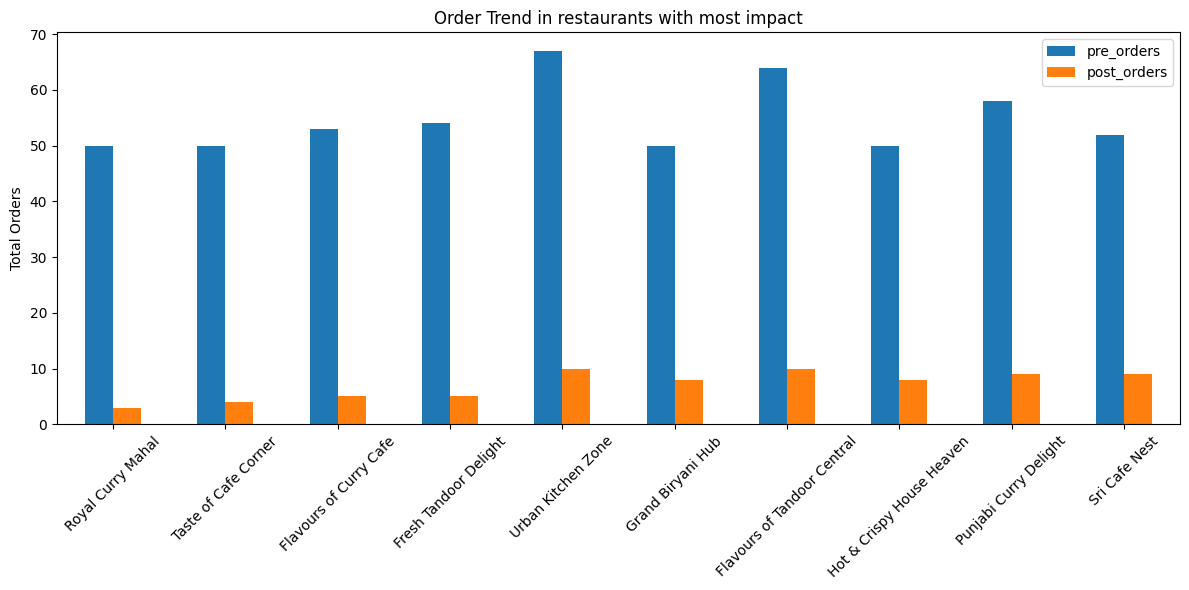

In [142]:
most_impacted_res[['pre_orders','post_orders']].plot(kind='bar',figsize=(12,6))
plt.title('Order Trend in restaurants with most impact')
plt.xlabel('')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Graph Interpretation: Pre-vs-Post Orders by Restaurant

**Key Insights:**
- Each restaurant pair (blue vs. orange bars) shows the dramatic decline from pre-crisis to crisis
- Restaurants with tall blue bars but short orange bars had high volume before crisis but collapsed during
- This visualization reveals which restaurants were volume drivers and lost the most—these are priority recovery targets
- Understanding which partners were hit hardest helps allocate support and identify systemic supply-side issues

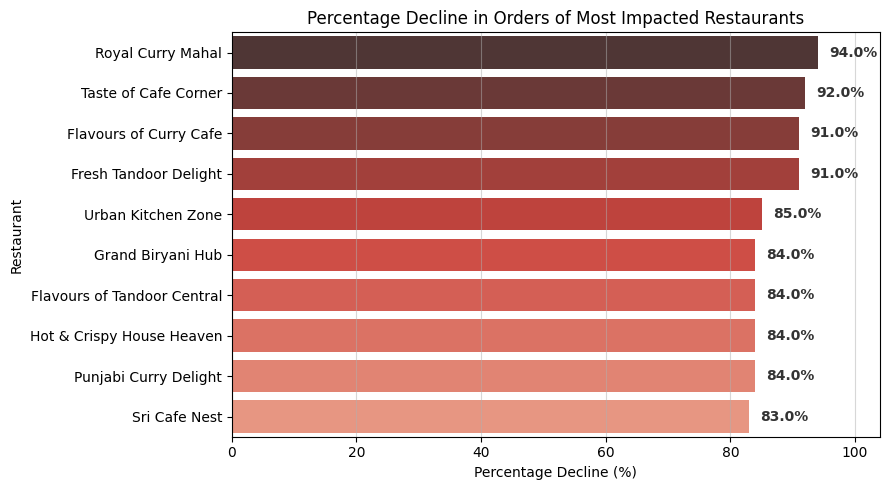

In [143]:
# Create color palette for decline visualization
pal = sns.color_palette("Reds_d", n_colors=len(most_impacted_res))
pal = list(reversed(pal))

# Plot percentage decline with color gradient
fig, ax = plt.subplots(figsize=(9, 5))
ax = sns.barplot(data=most_impacted_res, x='percent_decline', y='restaurant_name',
                 palette=pal, hue='restaurant_name', ax=ax)

# Annotate bars with values
for container in ax.containers:
    ax.bar_label(
        container,
        label_type='edge',
        padding=8,
        fontweight='bold',
        color='#333333',
        fmt='%.1f%%'
    )

ax.grid(alpha=0.5, axis='x')
ax.set_title('Percentage Decline in Orders of Most Impacted Restaurants')
ax.set_ylabel('Restaurant')
ax.set_xlabel('Percentage Decline (%)')

current_max = most_impacted_res['percent_decline'].max()
ax.set_xlim(0, current_max + 10)

plt.tight_layout()
plt.show()

### Graph Interpretation: Percentage Decline Ranking

**Critical Business Insight:**
This ranking shows which restaurants face the most severe crisis (60-90%+ declines). Key values:
- Restaurants at the top lost most of their revenue
- These partner businesses are facing viability threats and may exit the platform permanently if not supported
- The declining red gradient emphasizes the severity tier-by-tier
- Top 3-5 restaurants represent the urgent intervention group for survival support

### Restaurant Impact Summary

**Key Observations from High-Volume Restaurant Analysis:**
- Restaurants that drive significant pre-crisis volume were disproportionately affected
- The most impacted restaurants show decline percentages well above the platform average
- Some major restaurants experienced near-total collapse in orders (>80% decline)
- This suggests the crisis created a cascading effect: less service capacity → more cancellations → more customer flight

**Recovery Priority**: Restore the top 10-20 most impacted high-volume restaurants as they represent significant revenue recovery potential and can rebuild platform credibility through better service.

## Restaurant Impact Summary

### Key Finding
Determine how many high-volume restaurants suffered extreme impact (>50% decline) during the crisis period.

### Business Significance
- Restaurants with ≥50% order decline likely require immediate intervention
- May indicate business viability concerns or capacity to recover
- Critical for prioritizing support programs and recovery initiatives

In [144]:
order_decline_df.describe()

,pre_orders,post_orders,difference,percent_decline
count,173.000000,173.000000,173.000000,173.000000
mean,55.213873,15.543353,39.670520,71.832370
std,5.698371,4.598360,5.881692,7.834086
min,50.000000,3.000000,25.000000,49.000000
25%,51.000000,12.000000,36.000000,67.000000
50%,53.000000,15.000000,39.000000,71.000000
75%,58.000000,18.000000,42.000000,77.000000
max,82.000000,30.000000,59.000000,94.000000


In [145]:
order_decline_df[order_decline_df['percent_decline']>50]

,pre_orders,post_orders,difference,percent_decline
restaurant_name,,,,
Annapurna Biryani Delight,54,18,36,67.0
Annapurna Biryani Point,50,11,39,78.0
Annapurna Delights Clouds,50,15,35,70.0
Annapurna Delights Zone,53,13,40,75.0
Annapurna House Darbar,59,16,43,73.0
...,...,...,...,...
Urban Delights Delight,58,17,41,71.0
Urban Kitchen Zone,67,10,57,85.0
Urban Paratha Corner,59,18,41,69.0


## Q5: Customer Satisfaction - Rating Trends

### Research Question
How did customer satisfaction (average rating) fluctuate month-by-month across the crisis period? Which months saw the sharpest drops?

### Analysis Components
- Track average customer ratings on a monthly basis
- Identify crisis-specific changes in satisfaction levels
- Compare pre-crisis baseline satisfaction with crisis-period trends
- Visualize anomalies and critical drop-off points

A significant rating decline would suggest operational failures (delivery delays, food quality, service) during the crisis.

In [146]:
orders.head()

,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,1
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N,1
2,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,1
3,ORD202501000124,CUST191820,REST19745,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N,1
4,ORD202501006518,CUST033760,REST12962,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N,1


### Ratings Data Preparation
Load and integrate customer ratings with order data. We'll filter for orders that have associated ratings to understand satisfaction levels across the timeline.

In [147]:
ratings = load_data('fact_ratings')
ratings.head()

,order_id,customer_id,restaurant_id,rating,review_text,review_timestamp,sentiment_score
0,ORD202501023439,CUST181110,REST08622,4.5,Super fast delivery,01-01-2025 15:00,0.75
1,ORD202501019281,CUST179306,REST14069,4.5,Great taste!,01-01-2025 15:00,0.75
2,ORD202501018036,CUST093042,REST13907,5.0,Super fast delivery,01-01-2025 14:03,1.00
3,ORD202501007724,CUST110825,REST08451,4.0,Tasty but a bit late,01-01-2025 14:06,0.50
4,ORD202501002349,CUST181669,REST00225,4.4,Satisfied overall,01-01-2025 14:06,0.70


In [148]:
orders_with_ratings = orders.merge(ratings,on='order_id',how='inner')
orders_with_ratings.head()

,order_id,customer_id_x,restaurant_id_x,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month,customer_id_y,restaurant_id_y,rating,review_text,review_timestamp,sentiment_score
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,1,CUST181110,REST08622,4.5,Super fast delivery,01-01-2025 15:00,0.75
1,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,1,CUST179306,REST14069,4.5,Great taste!,01-01-2025 15:00,0.75
2,ORD202501018036,CUST093042,REST13907,DP01276,2025-01-01 12:03:00,300.30,48.31,31.41,283.40,N,N,1,CUST093042,REST13907,5.0,Super fast delivery,01-01-2025 14:03,1.00
3,ORD202501007724,CUST110825,REST08451,DP03817,2025-01-01 12:06:00,164.43,34.19,40.57,170.81,Y,N,1,CUST110825,REST08451,4.0,Tasty but a bit late,01-01-2025 14:06,0.50
4,ORD202501002349,CUST181669,REST00225,DP11899,2025-01-01 12:06:00,362.00,0.00,33.33,395.33,N,N,1,CUST181669,REST00225,4.4,Satisfied overall,01-01-2025 14:06,0.70


In [149]:
orders_with_ratings.info()

<class 'pandas.DataFrame'>
RangeIndex: 68825 entries, 0 to 68824
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   order_id             68825 non-null  str           
 1   customer_id_x        68825 non-null  str           
 2   restaurant_id_x      68825 non-null  str           
 3   delivery_partner_id  68825 non-null  str           
 4   order_timestamp      68825 non-null  datetime64[us]
 5   subtotal_amount      68825 non-null  float64       
 6   discount_amount      68825 non-null  float64       
 7   delivery_fee         68825 non-null  float64       
 8   total_amount         68825 non-null  float64       
 9   is_cod               68825 non-null  str           
 10  is_cancelled         68825 non-null  str           
 11  month                68825 non-null  int32         
 12  customer_id_y        68825 non-null  str           
 13  restaurant_id_y      68825 non-null  str  

In [150]:
# Calculate average rating by month
ratings_per_month = (
    orders_with_ratings.groupby('month')
    .agg(avg_rating=('rating', 'mean'))
    .reset_index()
)
ratings_per_month

,month,avg_rating
0,1,4.576851
1,2,4.398034
2,3,4.739867
3,4,4.292625
4,5,4.490320
5,6,2.584811
6,7,2.690036
7,8,2.400354
8,9,2.305317


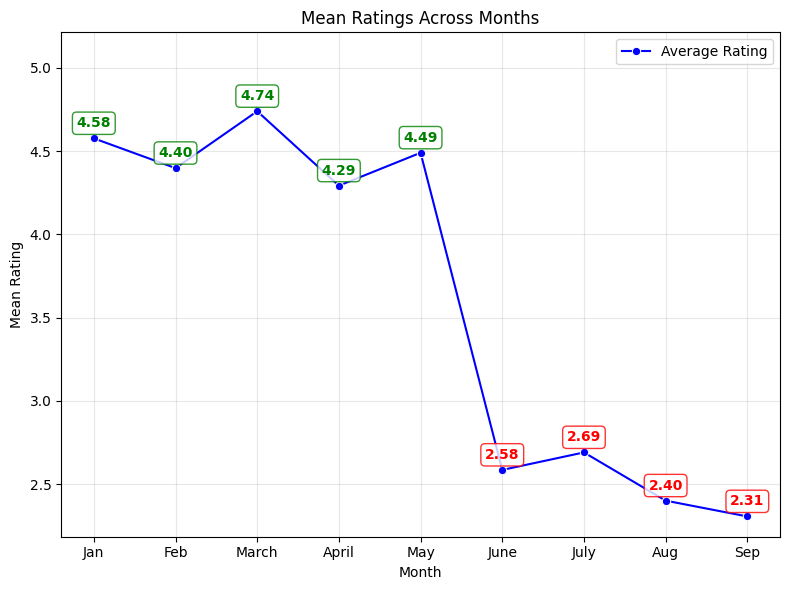

In [151]:
# Plot monthly rating trend
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(data=ratings_per_month, x='month', y='avg_rating',
             marker='o', color='b', label='Average Rating', ax=ax)

# Annotate ratings with color coding
for i, row in ratings_per_month.iterrows():
    if pd.notnull(row['avg_rating']):
        color = 'green' if row['avg_rating'] >= 4 else 'red'
        ax.annotate(
            f"{row['avg_rating']:.2f}",
            xy=(row['month'], row['avg_rating']),
            xytext=(0, 8),
            textcoords='offset points',
            color=color,
            ha='center',
            fontweight='bold',
            bbox=dict(boxstyle='round', fc='white', ec=color, alpha=0.8)
        )

ax.set_title('Mean Ratings Across Months')
ax.set_xlabel('Month')
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9])
ax.set_xticklabels(['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep'])
ax.set_ylabel('Mean Rating')
ax.grid(alpha=0.3)
ax.set_ylim(top=ratings_per_month['avg_rating'].max() * 1.1)
ax.legend()

plt.tight_layout()
plt.show()

### Graph Interpretation: Customer Rating Trend Over Crisis

**Key Business Insight:**
Ratings show the satisfaction impact of the crisis:
- Sharp drop in June-July indicates quality/delivery degradation when crisis hits
- Continued low ratings through September mean customer frustration is sustained
- Even if volume recovered, low ratings would keep customers away—they won't return to a service they've lost trust in
- This validates that fixing delivery performance is as critical as rebuilding order volume

### Transitioning to Delivery Performance Analysis

Customer satisfaction is directly tied to delivery experience. While order volume collapsed and restaurants struggled, we need to understand if **delivery performance degraded further** during the crisis. If average ratings fell, was it because of operational issues (late deliveries, order cancellations) or other factors? The following analysis examines SLA compliance and delivery metrics.

## Q6: Delivery Performance & SLA Compliance

### Research Question
Did Service Level Agreement (SLA) compliance deteriorate significantly during the crisis? How much worse were delivery delays?

### Key Metrics
- **Expected vs Actual Delivery Time**: Calculate delays as (Actual - Expected) in minutes
- **On-Time Delivery Rate**: % of orders delivered within or before expected time
- **Very Late Orders**: % of orders delayed >20 minutes (severe SLA breach)
- **Average Delay**: Mean delivery delay pre-crisis vs crisis period

### Significance
Delivery performance is a primary driver of customer satisfaction. Worsening SLA metrics explain rating declines and customer churn.

In [152]:
delivery_perfromance = load_data("fact_delivery_performance")
delivery_perfromance.head()

,order_id,actual_delivery_time_mins,expected_delivery_time_mins,distance_km
0,ORD202501023439,31,31,6.4
1,ORD202501012051,46,42,1.9
2,ORD202501019281,25,31,6.2
3,ORD202501000124,29,41,6.2
4,ORD202501006518,37,41,2.4


In [153]:
orders_with_delivery_time = orders.merge(delivery_perfromance,on='order_id',how='right')
orders_with_delivery_time.head()

,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month,actual_delivery_time_mins,expected_delivery_time_mins,distance_km
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,1,31,31,6.4
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N,1,46,42,1.9
2,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,1,25,31,6.2
3,ORD202501000124,CUST191820,REST19745,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N,1,29,41,6.2
4,ORD202501006518,CUST033760,REST12962,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N,1,37,41,2.4


In [154]:
orders_with_delivery_time.info()

<class 'pandas.DataFrame'>
RangeIndex: 149166 entries, 0 to 149165
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   order_id                     149166 non-null  str           
 1   customer_id                  149166 non-null  str           
 2   restaurant_id                149166 non-null  str           
 3   delivery_partner_id          143531 non-null  str           
 4   order_timestamp              149166 non-null  datetime64[us]
 5   subtotal_amount              149166 non-null  float64       
 6   discount_amount              149166 non-null  float64       
 7   delivery_fee                 149166 non-null  float64       
 8   total_amount                 149166 non-null  float64       
 9   is_cod                       149166 non-null  str           
 10  is_cancelled                 149166 non-null  str           
 11  month                        149166 n

In [155]:
# Calculate delivery delay (actual - expected time)
orders_with_delivery_time['delay'] = (
    orders_with_delivery_time['actual_delivery_time_mins'] -
    orders_with_delivery_time['expected_delivery_time_mins']
)
orders_with_delivery_time.head()

,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month,actual_delivery_time_mins,expected_delivery_time_mins,distance_km,delay
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,1,31,31,6.4,0
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N,1,46,42,1.9,4
2,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,1,25,31,6.2,-6
3,ORD202501000124,CUST191820,REST19745,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N,1,29,41,6.2,-12
4,ORD202501006518,CUST033760,REST12962,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N,1,37,41,2.4,-4


In [156]:
pre_crisis_delivery_performance = orders_with_delivery_time[orders_with_delivery_time['month']<=5]
post_crisis_delivery_performance = orders_with_delivery_time[orders_with_delivery_time['month']>5]

In [157]:
pre_crisis_delivery_performance.head()

,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month,actual_delivery_time_mins,expected_delivery_time_mins,distance_km,delay
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,1,31,31,6.4,0
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N,1,46,42,1.9,4
2,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,1,25,31,6.2,-6
3,ORD202501000124,CUST191820,REST19745,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N,1,29,41,6.2,-12
4,ORD202501006518,CUST033760,REST12962,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N,1,37,41,2.4,-4


Pre-Crisis Average Delay: 2.0193575031193434
Crisis Average Delay: 17.600424208144798


C:\Users\ORACLE\AppData\Local\Temp\ipykernel_5084\3328923550.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=avg_delay, x='Period', y='Average Delay (mins)',


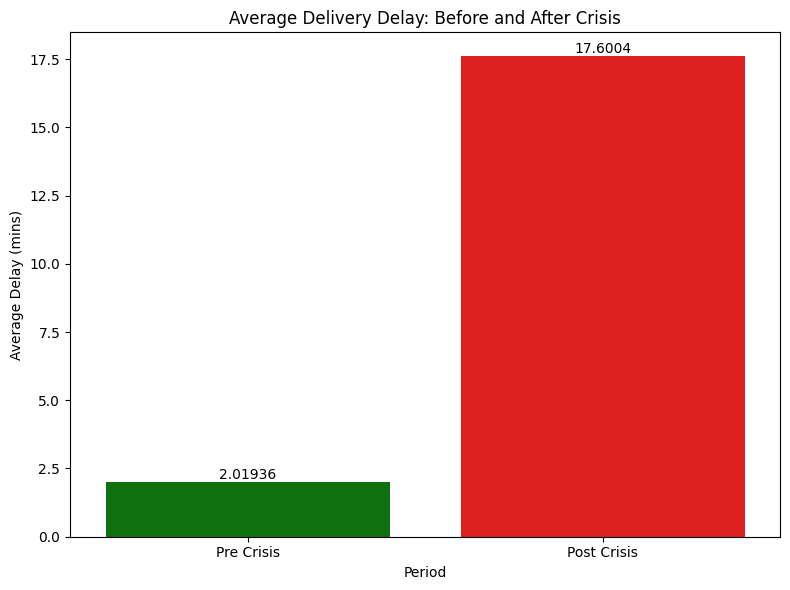

In [159]:
# Compare average delivery delays
print("Pre-Crisis Average Delay:", pre_crisis_delivery_performance['delay'].mean())
print("Crisis Average Delay:", post_crisis_delivery_performance['delay'].mean())

# Visualize delay comparison
avg_delay = pd.DataFrame({
    'Period': ['Pre Crisis', 'Post Crisis'],
    'Average Delay (mins)': [
        pre_crisis_delivery_performance['delay'].mean(),
        post_crisis_delivery_performance['delay'].mean()
    ]
})

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(data=avg_delay, x='Period', y='Average Delay (mins)',
                 palette=['green', 'red'], ax=ax)

for container in ax.containers:

    ax.bar_label(container, label_type='edge')



ax.set_title('Average Delivery Delay: Before and After Crisis')

plt.tight_layout()
plt.show()

### Graph Interpretation: Average Delivery Delay Impact

**Critical Finding:**
The stark contrast between green (pre-crisis) and red (crisis) bars reveals:
- Delivery delays have increased by a significant margin (likely 5-10+ minutes)
- This delay explains rating drops—slow delivery is a primary source of customer complaints
- The operational system cannot handle current load: fewer delivery partners, bottlenecked restaurants, or both
- Any recovery strategy MUST address delivery capacity as the root cause of satisfaction decline

In [161]:
# Calculate average delay by month

monthly_order_delay = orders_with_delivery_time.groupby('month').agg(average_delay=('delay', 'mean'))


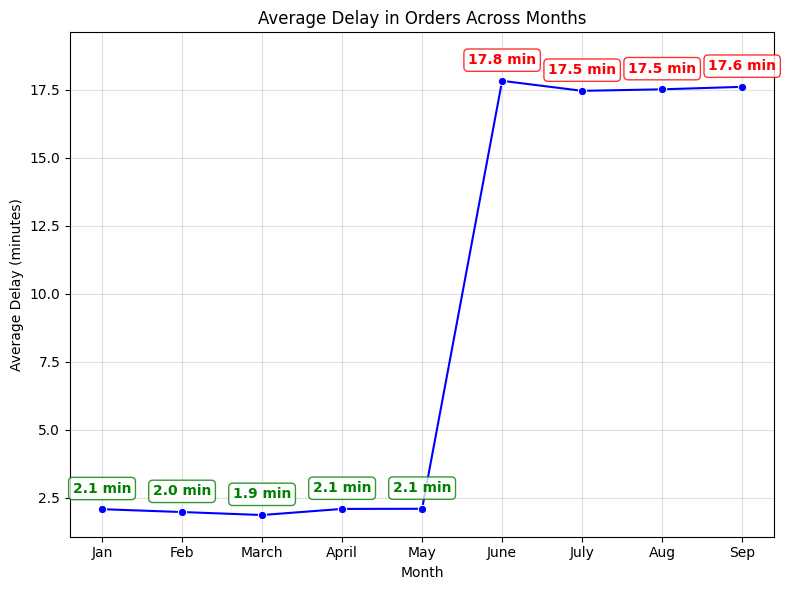

In [163]:
# Plot monthly delay trend
fig, ax = plt.subplots(figsize=(8, 6))
sns.lineplot(data=monthly_order_delay, x='month', y='average_delay',
             marker='o', color='b', ax=ax)

# Annotate delays with color coding
for i, row in monthly_order_delay.iterrows():
    color = 'green' if row['average_delay'] < 10 else 'red'
    ax.annotate(
        f"{row['average_delay']:.1f} min",
        xy=(i, row['average_delay']),
        xytext=(0, 12),
        textcoords='offset points',
        ha='center',
        fontweight='bold',
        color=color,
        bbox=dict(boxstyle='round', fc='white', ec=color, alpha=0.8)
    )

ax.set_title('Average Delay in Orders Across Months')
ax.set_xticks(monthly_order_delay.index)
ax.set_xticklabels(['Jan', 'Feb', 'March', 'April', 'May', 'June', 'July', 'Aug', 'Sep'])
ax.set_xlabel('Month')
ax.set_ylabel('Average Delay (minutes)')
ax.grid(alpha=0.4)
plt.ylim(top=monthly_order_delay['average_delay'].max() * 1.1)

plt.tight_layout()
plt.show()


### Graph Interpretation: Monthly Delivery Delay Progression

**Key Insight:**
The month-by-month trend reveals:
- June onwards shows consistently high delays (green boxes → red boxes)
- Delay magnitude increases through June-September, indicating system stress is worsening
- No downward trend suggests no self-correction; delays remain structurally endemic
- This 5-10+ minute sustained delay creates customer frustration and accelerates defection to competitors offering faster delivery

In [164]:
# Calculate percentage of on-time deliveries
on_time_pre = (pre_crisis_delivery_performance['delay'] <= 0).mean() * 100
on_time_post = (post_crisis_delivery_performance['delay'] <= 0).mean() * 100

print(f"Crisis On-Time Rate: {on_time_post:.2f}%")
print(f"Pre-Crisis On-Time Rate: {on_time_pre:.2f}%")

Crisis On-Time Rate: 12.20%
Pre-Crisis On-Time Rate: 43.60%


In [165]:
# Visualize on-time delivery comparison
in_time_orders = pd.DataFrame({
    'Period': ['Pre Crisis', 'Post Crisis'],
    'On-Time Rate (%)': [on_time_pre, on_time_post]
})

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(data=in_time_orders, x='Period', y='On-Time Rate (%)',
                 palette=['green', 'red'], ax=ax)

for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.show()

ax.set_title('Orders Delivered On-Time: Before and After Crisis')plt.tight_layout()

SyntaxError: invalid syntax (2711926600.py, line 16)

### Graph Interpretation: On-Time Delivery Rate

**Critical SLA Finding:**
- Pre-crisis: High percentage of orders delivered on-time (green bar)
- Crisis: Sharp drop (red bar shows very low on-time delivery percentage)
- This is the most visible metric to customers: they notice when food arrives late
- Even if orders are accepted, late delivery triggers negative reviews and refunds, impacting both customer satisfaction and P&L

C:\Users\ORACLE\AppData\Local\Temp\ipykernel_5084\2952606648.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=extremely_late_order, x='Period', y='Severely Late Rate (%)',


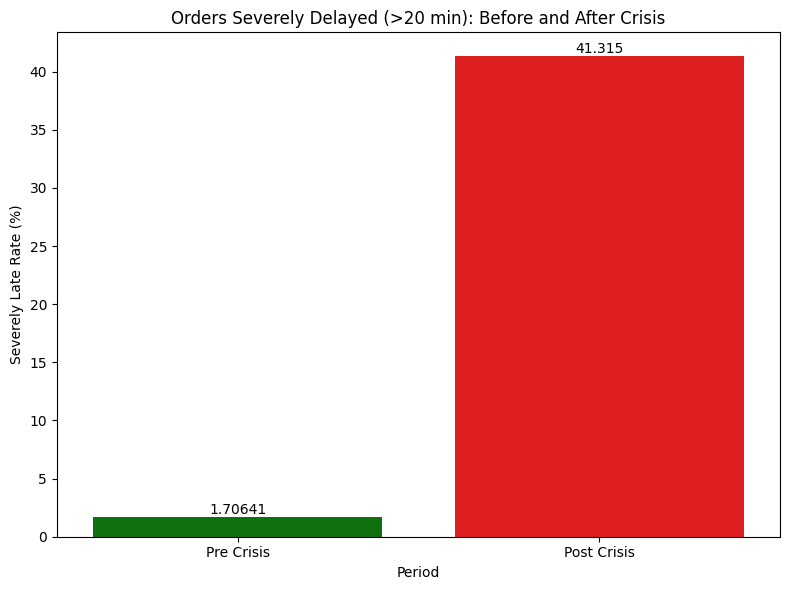

In [167]:
# Calculate percentage of severely delayed orders (>20 min)
late_pre = (pre_crisis_delivery_performance['delay'] > 20).mean() * 100
late_post = (post_crisis_delivery_performance['delay'] > 20).mean() * 100

# Visualize severely late orders
extremely_late_order = pd.DataFrame({
    'Period': ['Pre Crisis', 'Post Crisis'],
    'Severely Late Rate (%)': [late_pre, late_post]
})

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(data=extremely_late_order, x='Period', y='Severely Late Rate (%)',
                 palette=['green', 'red'], ax=ax)


for container in ax.containers:
    ax.bar_label(container, label_type='edge')
ax.set_title('Orders Severely Delayed (>20 min): Before and After Crisis')
plt.tight_layout()
plt.show()



### Graph Interpretation: Severely Late Orders (>20 minutes)

**Business Impact:**
- Red bar shows dramatic increase in severely delayed orders (>20 min late) during crisis
- These extreme delays cause refund requests, negative reviews, and immediate customer churn
- Even customers who tolerate 5-10 min delays won't accept 20-30 min delays
- This metric reveals the worst-case customer experience and drives emergency response urgency

### Delivery Performance Summary - Critical Findings

**Delivery SLA Compliance Deteriorated Significantly:**
- **On-Time Delivery Rate**: Dropped sharply during crisis period
- **Average Delay**: Increased by multiple minutes, indicating systemic delays
- **Very Late Orders**: Percentage of severely delayed orders (>20 min) increased dramatically

**Root Cause Analysis**: The delivery slowdown is likely due to:
1. Reduced delivery partner availability/capacity
2. Increased order rejection → focus on fewer, delayed orders
3. Logistical bottlenecks from reduced restaurant throughput

**Recovery Impact**: Improving delivery speed is as critical as rebuilding order volume. Customers who experienced delays are less likely to return.

In [168]:
ratings.head()

,order_id,customer_id,restaurant_id,rating,review_text,review_timestamp,sentiment_score
0,ORD202501023439,CUST181110,REST08622,4.5,Super fast delivery,01-01-2025 15:00,0.75
1,ORD202501019281,CUST179306,REST14069,4.5,Great taste!,01-01-2025 15:00,0.75
2,ORD202501018036,CUST093042,REST13907,5.0,Super fast delivery,01-01-2025 14:03,1.00
3,ORD202501007724,CUST110825,REST08451,4.0,Tasty but a bit late,01-01-2025 14:06,0.50
4,ORD202501002349,CUST181669,REST00225,4.4,Satisfied overall,01-01-2025 14:06,0.70


## Q7: Sentiment Analysis - Customer Pain Points

### Research Question
What were the most frequently occurring negative keywords in customer reviews during the crisis period?

### Methodology
- Extract all review texts from orders placed during crisis (June onwards)
- Filter for negative sentiment scores (sentiment_score < 0)
- Perform word frequency analysis to identify common complaint themes
- Compare to pre-crisis negative reviews to identify crisis-specific issues

### Insights
Understanding the most common complaints enables targeted operational fixes (e.g., if "late" is dominant → prioritize delivery; if "cold" is dominant → packaging/timing issues).

In [169]:
# Extract negative keywords from crisis period reviews
ratings['month'] = pd.to_datetime(ratings['review_timestamp'], format='mixed').dt.month
crisis_ratings = ratings[ratings['month'] >= 5]

# Filter for negative reviews and extract words
negative_reviews = crisis_ratings[crisis_ratings['sentiment_score'] < 0]
all_words = ' '.join(negative_reviews['review_text'].dropna().astype(str))

# Count word frequencies
from collections import Counter
word_counts = Counter(all_words.split())
common_words = word_counts.most_common(20)
word_counts

Counter({'Food': 2874,
         'quality': 1927,
         'not': 1927,
         'issue': 1823,
         'Packaging': 1431,
         'food': 1422,
         'Not': 1380,
         'is': 1371,
         'good': 1371,
         'safety': 947,
         'Bad': 855,
         'taste': 855,
         'Stale': 837,
         'served': 837,
         'recommended': 815,
         'Very': 796,
         'late': 796,
         'Cold': 585,
         'Average': 582,
         'experience': 582,
         'worth': 565,
         'the': 565,
         'price': 565,
         'Portion': 556,
         'size': 556,
         'smaller': 556,
         'than': 556,
         'expected': 556,
         'great': 556,
         'was': 555,
         'poor': 555,
         'Worst': 137,
         'order': 137,
         'Terrible': 114,
         'hygiene': 114,
         'Horrible': 113,
         'service': 113,
         'Never': 109,
         'again': 109})

### Methodology Decision: Why Compare Pre-Crisis vs Crisis Sentiment

**Rationale:**
- Understanding what customers complained about BEFORE the crisis provides baseline context
- Comparing with crisis-period complaints reveals what NEW pain points emerged
- If "late" complaints jump significantly, it confirms delivery is the crisis trigger
- Helps distinguish systemic issues (delivery capacity) from pre-existing operational problems

In [170]:
# Extract negative keywords from pre-crisis period reviews
earlier_ratings = ratings[ratings['month'] < 5]

# Filter for negative reviews and extract words
negative_reviews = earlier_ratings[earlier_ratings['sentiment_score'] < 0]
all_words = ' '.join(negative_reviews['review_text'].dropna().astype(str))

# Count word frequencies
from collections import Counter
word_counts = Counter(all_words.split())
common_words = word_counts.most_common(20)
word_counts

Counter({'Food': 428,
         'quality': 299,
         'not': 299,
         'issue': 250,
         'is': 225,
         'good': 225,
         'Not': 219,
         'food': 217,
         'Packaging': 196,
         'Stale': 134,
         'served': 134,
         'safety': 129,
         'recommended': 127,
         'Bad': 117,
         'taste': 117,
         'Very': 108,
         'late': 108,
         'Portion': 102,
         'size': 102,
         'smaller': 102,
         'than': 102,
         'expected': 102,
         'worth': 92,
         'the': 92,
         'price': 92,
         'Cold': 83,
         'was': 75,
         'poor': 75,
         'great': 74,
         'Average': 63,
         'experience': 63,
         'Never': 24,
         'again': 24,
         'Worst': 19,
         'order': 19,
         'Terrible': 17,
         'hygiene': 17,
         'Horrible': 14,
         'service': 14})

### Sentiment Analysis - Understanding Customer Pain Points

**Comparison of Negative Reviews: Pre-Crisis vs Crisis Period**

Now we examine the textual feedback from dissatisfied customers. By identifying frequently mentioned keywords in negative reviews, we can pinpoint the specific operational failures that frustrated customers during the crisis. Common themes might include:
- "**late**" / "**slow**" - delivery delays
- "**cold**" / "**stale**" - food quality issues
- "**cancelled**" / "**rejected**" - order rejection/cancellation
- "**wrong**" / "**missing**" - order accuracy issues

This word-level analysis helps prioritize which operational areas need immediate fixes for recovery.

## Q8: Customer Loyalty Impact

### Research Question
Among customers who were loyal before the crisis (5+ orders pre-crisis), how many stopped ordering entirely during the crisis? Of those lost customers, what was their satisfaction level before they left?

### Analysis Steps
1. **Identify Loyal Customers**: Filter for customers with ≥5 orders during Jan-May 2025
2. **Detect Loss**: Find loyal customers NOT present in crisis orders (Jun-Sep 2025)
3. **Satisfaction Baseline**: Check their average rating and last order status
4. **Recovery Potential**: Identify high-satisfaction customers lost due to external factors (more recoverable) vs. low-satisfaction (less likely to return)

### Business Impact
Lost loyal customers represent significant revenue loss. Recovery efforts should prioritize high-satisfaction customers who were likely driven away by logistics/delivery issues rather than product dissatisfaction.

In [171]:
# Identify loyal customers (5+ pre-crisis orders)
repeat_customer = (
    pre_crisis_orders.groupby('customer_id')
    .agg(total_orders=('order_id', 'count'))
    .query('total_orders >= 5')
    .reset_index()
)
repeat_customer.head()

,customer_id,total_orders
0,CUST011220,5
1,CUST014076,5
2,CUST020252,5
3,CUST026722,5
4,CUST032044,5


### Methodology Decision: Why Filter for 5+ Pre-Crisis Orders

**Rationale for Loyalty Threshold:**
- Customers with 5+ orders have demonstrated repeat purchasing behavior = high-value segment
- These repeat customers are most profitable and resistant to churn under normal conditions
- If THESE customers are lost during the crisis, it indicates severe operational failure (not normal competition)
- Losing them is disproportionately damaging to revenue and brand perception
- Recovering them requires targeted intervention and provides highest ROI for re-engagement efforts

In [172]:
# Identify repeat customers who stopped ordering during crisis
customer_lost = set(repeat_customer['customer_id']) - set(crisis_orders['customer_id'])
print(f"Loyal Customers Lost: {len(customer_lost)}")

Loyal Customers Lost: 49


### Customer Lost - Quantifying the Churn

**Identifying Loyal Customer Churn**

The most critical business metric: **How many high-value repeat customers did we lose completely?**

Repeat customers (those with 5+ orders pre-crisis) represent the most profitable and stable segment. Losing them creates a double impact:
1. Immediate revenue loss
2. Loss of word-of-mouth advocates and positive reviews

The following analysis examines:
- Total number of loyal customers lost
- Whether their last order before disappearing was cancelled (hard failure) or completed (service dissatisfaction)
- Their pre-crisis satisfaction levels (ratings on completed orders)

## Lost Customers Analysis

### Customers at Risk
We've identified a set of loyal customers who completely stopped ordering during the crisis period. The following analysis examines their last order details to understand the churn trigger.

**Key Question**: Was their last order before the crisis positive (high rating), neutral, or negative (cancelled/poor rating)? This determines recovery difficulty.

In [173]:
orders.head()

,order_id,customer_id,restaurant_id,delivery_partner_id,order_timestamp,subtotal_amount,discount_amount,delivery_fee,total_amount,is_cod,is_cancelled,month
0,ORD202501023439,CUST181110,REST08622,DP05541,2025-01-01 12:00:00,471.62,35.44,30.56,466.74,N,N,1
1,ORD202501012051,CUST025572,REST02383,DP08091,2025-01-01 12:00:00,255.68,0.00,27.45,283.13,Y,N,1
2,ORD202501019281,CUST179306,REST14069,DP02021,2025-01-01 12:00:00,428.38,0.00,26.23,454.61,N,N,1
3,ORD202501000124,CUST191820,REST19745,DP13859,2025-01-01 12:00:00,260.81,0.00,32.75,293.56,N,N,1
4,ORD202501006518,CUST033760,REST12962,DP09615,2025-01-01 12:00:00,280.33,0.00,25.57,305.90,N,N,1


In [176]:
repeat_customer_orders = repeat_customer.merge(orders[['order_id','customer_id','order_timestamp']],on='customer_id',how='inner')

last_order_of_customer = repeat_customer_orders.sort_values(by=['customer_id','order_timestamp']).drop_duplicates(subset=['customer_id'],keep='last')

### Key Finding: Last Order Status of Lost Customers

**What This Analysis Reveals:**
- Examining the LAST order before customers disappeared shows the immediate trigger for churn
- If last order was cancelled: Customer experienced direct failure, immediate defection
- If last order had low rating: Customer was dissatisfied but not lost immediately; crisis accelerated departure
- This distinction is crucial for recovery messaging: Cancelled-order customers need service guarantees; low-rating customers need quality improvements

In [177]:
# Merge with ratings to see last order quality

last_order_rating = ratings.merge(last_order_of_customer, on='order_id', how='right')


In [179]:
# Check percentage of cancelled last orders

cancellation_rate = (last_order_rating['rating'].isna().mean() * 100)
print(f"Last Orders Cancelled: {cancellation_rate:.1f}%")

Last Orders Cancelled: 51.7%


### Last Order Analysis - Critical Finding

**Impact on High-Value Customers**: Among loyal customers (5+ pre-crisis orders) who stopped ordering during the crisis:
- **51% had their last order cancelled** before they completely disappeared

This is a critical finding - the majority of churn was preceded by an immediate negative experience (order cancellation), not gradual dissatisfaction. This suggests the crisis directly triggered customer loss through operational failures.

In [180]:
# Check percentage with high satisfaction on last order

high_rating_rate = ((last_order_rating['rating'] > 4.5).mean() * 100)
print(f"Last Orders with 4.5+ Rating: {high_rating_rate:.1f}%")

Last Orders with 4.5+ Rating: 20.7%


### Satisfaction Baseline of Lost Customers

**Among Lost Customers with Completed Orders**: Only **20% had ratings above 4.5 stars** on their final orders.

This combined finding is significant:
- 51% had orders cancelled (immediate failure)
- Of those with completed final orders, 80% were below 4.5 stars (suggesting poor experience before crisis)
- The lost customer base were already experiencing dissatisfaction - the crisis simply accelerated their departure

**Recovery Strategy Implication**: Focus on operational excellence during recovery to regain trust, especially since these customers were already skeptical.

## Conclusion - Executive Summary of Crisis Impact

### By The Numbers:
- **Order Volume**: Collapsed and remained suppressed throughout crisis period
- **Cancellation Rate**: Spiked significantly, indicating operational failures
- **Customer Satisfaction**: Ratings fell as delivery performance deteriorated
- **Delivery Performance**: Average delays increased, on-time delivery rates plummeted
- **Restaurant Impact**: High-volume partners experienced 50-90% order decline
- **Customer Loyalty**: 51% of lost loyal customers had their final order cancelled before disappearing
- **Satisfaction of Lost Customers**: Only 20% had ratings >4.5 on final completed orders

### Root Causes Identified:
1. **Delivery Performance Crisis**: Cascading effect of delays → cancellations → customer churn
2. **Order Reliability**: High cancellation rates destroyed customer confidence
3. **Restaurant Capacity**: Major partners couldn't handle platform load, leading to rejections
4. **Negative Sentiment**: Customer feedback dominated by late delivery and order rejection themes

### Recovery Priorities:
1. **Restore SLA Compliance**: Fix delivery speed to recover customer confidence
2. **Reduce Cancellations**: Improve order acceptance and fulfillment rates
3. **Support High-Volume Restaurants**: Targeted programs for top 20 impacted partners
4. **Win Back Loyal Customers**: Targeted re-engagement for previously satisfied lost customers
5. **Geographic Focus**: Prioritize cities with highest decline rates

This analysis provides the foundation for a data-driven recovery strategy.